In [2]:
import gluonts
gluonts.__version__

'0.4.2'

In [3]:
import mxnet
mxnet.__version__

'1.4.1'

In [4]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


In [6]:
dataname = "m4_daily"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:downloading and processing m4_daily


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/test/data.json


In [7]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_wee

In [8]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [9]:
train_entry

{'start': Timestamp('1750-01-01 00:00:00', freq='D'),
 'target': array([1017.1, 1019.3, 1017. , ..., 2022.1, 2031.6, 2029.7], dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/train/data.json'), line=1), row=1)}

## Plot Series

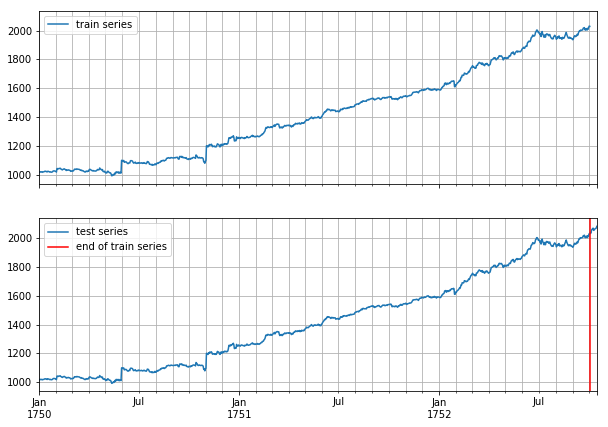

In [10]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [11]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [12]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df


## Results

In [18]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_monthly", seed=i, epochs=200, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 2431163
100%|██████████| 200/200 [00:16<00:00, 12.06it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[0] Elapsed time 16.595 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.466476
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:17<00:00, 11.72it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[1] Elapsed time 17.062 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.974738
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:15<00:00, 12.57it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[2] Elapsed time 15.913 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.886649
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:15<00:00, 12.82it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[3] Elapsed time 15.603 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.605441
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:15<00:00, 12.63it/s, avg_epoch

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.282933
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 200/200 [00:15<00:00, 12.69it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[37] Elapsed time 15.761 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.823653
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 200/200 [00:15<00:00, 12.54it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[38] Elapsed time 15.959 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.009572
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 200/200 [00:15<00:00, 12.57it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[39] Elapsed time 15.913 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.363812
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 200/200 [00:15<00:00, 12.84it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[40] Elapsed time 15.589 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.148329
INFO:root:Epoch[41] Learning rate is 0.0005
100%

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.164721
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:16<00:00, 12.35it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[73] Elapsed time 16.195 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.694778
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:15<00:00, 12.77it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[74] Elapsed time 15.668 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.558398
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:16<00:00, 12.45it/s, avg_epoch_loss=6]  
INFO:root:Epoch[75] Elapsed time 16.071 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.998400
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:16<00:00, 12.43it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[76] Elapsed time 16.097 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.732847
INFO:root:Epoch[77] Learning rate is 6.25

100%|██████████| 200/200 [00:16<00:00, 12.48it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[109] Elapsed time 16.037 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.666904
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 200/200 [00:16<00:00, 12.28it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[110] Elapsed time 16.288 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.714600
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.78it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[111] Elapsed time 15.660 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.143329
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.52it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[112] Elapsed time 15.978 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.576034
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:16<00:00, 11.90it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[113] Elapsed 

INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=5.807083
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 200/200 [00:17<00:00, 11.49it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[146] Elapsed time 17.402 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.913693
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.65it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[147] Elapsed time 15.814 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.245211
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.83it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[148] Elapsed time 15.601 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.189045
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 13.06it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[149] Elapsed time 15.317 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.664834
INFO:root:Epoch[150] Learning rate is 5

100%|██████████| 200/200 [00:15<00:00, 12.77it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[182] Elapsed time 15.687 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.010189
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.73it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[183] Elapsed time 15.713 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.041692
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:16<00:00, 12.37it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[184] Elapsed time 16.183 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.375037
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:16<00:00, 12.30it/s, avg_epoch_loss=6.7] 
INFO:root:Epoch[185] Elapsed time 16.262 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.696730
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:15<00:00, 12.85it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[186] Elapsed 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.032404  0.135437  15.280889            0.121905            0.079612   

   seed  epochs  num_batches  
0    42     200          200  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 2431163
100%|██████████| 200/200 [00:16<00:00, 12.17it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[0] Elapsed time 16.456 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.691759
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:16<00:00, 12.28it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[1] Elapsed time 16.286 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.952450
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:16<00:00, 12.15it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[2] Elapsed time 16.458 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.892764
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:15<00:00, 12.57it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[3] Elapsed time 15.915 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.639001
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:15<00:00, 12.56it/s, avg_epoch

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.265756
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 200/200 [00:16<00:00, 12.41it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[37] Elapsed time 16.124 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.780647
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 200/200 [00:15<00:00, 12.65it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[38] Elapsed time 15.821 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.989745
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 200/200 [00:16<00:00, 12.27it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[39] Elapsed time 16.307 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.175085
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 200/200 [00:15<00:00, 12.74it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[40] Elapsed time 15.710 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.135414
INFO:root:Epoch[41] Learning rate is 0.0005
100%

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.212041
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:09<00:00, 20.48it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[73] Elapsed time 9.770 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.603055
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:09<00:00, 21.06it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[74] Elapsed time 9.498 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.612035
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:09<00:00, 20.36it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[75] Elapsed time 9.830 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.917021
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:09<00:00, 20.20it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[76] Elapsed time 9.904 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.651266
INFO:root:Epoch[77] Learning rate is 6.25e-05

KeyboardInterrupt: 